#### Lab2 - Basic anomaly detection algorithms

In this lab we will use some basic anomaly detection algorithms like average scores, KNN and LOF.

A few methods that will be useful to you throughout this lab session are:

**pyod.utils.data.generate_data_clusters** is used to generate clusters of sythetic data, its parameters include:
- number of training and test samples: `n_train=1000` `n_test=500`
- number of clusters and features: `n_clusters=2`, `n_features=2`
- contamination level: `contamination=0.1`
- characteristics of the clusters: `size=same`, `densitiy=same`, `dist=0.25`
- `random_state=None`
- `return_in_clusters=False`

**sklearn.datasets.make_blobs** is used to generate isotropic Gaussian clusters (covariance matrix can be represnted in this form $\Sigma =\sigma^2I$), it's parameters include:
- number of samples: `n_samples=100`
- number of features: `n_features=2`
- centers and standard deviation of the clusters: `centers=None`, `cluster_std=1.0`
- bounding box for each cluster center when centers are generated at random: `center_box = (-10.0, 10.0)`
- `shuffle=True`
- `random_state=None`
- `random_centers=False`

**sklearn.model_selection.train_test_split** splits datasets into random train and test subsets and include the parameters:
- input data: `*arrays`
- test data size and train data size: `test_size=None`, `train_size=None`
- `random_state=None`
- `shuffle=True`
- `stratify=None` - used to split in a stratified fashion

**scipy.io.loadmat** loads data from a MATLAB file and includes the folowing parmeters:
- `file_name`
- dictionary in which to insert matfile variables: `mdict=None`
- `appendmat=True`: to append the `.mat` extension to the end of the given filename

**pyod.utils.utility.standardizer** transforms data to zero-mean and unit variance; it includes the parameters:
- training samples and test samples: `X, X_t=None`

**pyod.models.combination.average** takes the average of the outlier scores; uses the following parameters:
- score matrix of shape (`n_samples`, `n_estimators`): `score`
- `estimator_weights=None` - for weighted average

**pyod.models.combination.maximization** takes the maximum score and includes the parameter:
- score matrix of shape (`n_samples`, `n_estimators`): `score`

**numpy.quantile** computes the q-th quantile of the data along the specified axis (the value below which the specified percentage of data falls); its parameters include:
- input array: `a`
- probability or sequence of probabilities of the quantiles to compute. Value must be $0$ and $1$ inclusive: `q` 

#### Exercises

#### Ex. 1
In this exercise we verify numerically the purpose of the leverage score discussed in class. Generate a random linear model $y = ax_1 + b + \epsilon$ where $\epsilon$ is random Gaussian noise and mean $\mu$ and variance $\sigma^2$. For various values of $\mu, \sigma^2$ generate data and compute the leverage score for all the points. Create four types of points: regular (low noise, close to the model), high variance on $x$, high variance on $y$ and finally high variance on both $x$ and $y$. Plot all results, group in subplots for the various values in noise variance. Mark on the plots the points with the highest leverage scores. Repeat the exercise for the $2D$ case $y = ax_1 + bx_2 + c + \epsilon$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

`x_small_std` vs `x_large_std`:
- this controls the horizontal spread.
- points generated with `x_small_std` will be clustered near the center of the `x-axis` (mean = 0).
- points generated with `x_large_std` will spread much farther out, creating potential leverage points.

`y_small_sigma` vs `y_large_sigma`:
- this controls the vertical scatter (noise).
- points generated with `y_small_sigma` will stick very close to the true regression line.
- points generated with `y_large_sigma` will be scattered far above or below the line, creating potential outliers with large residuals. 

In [9]:
def generate_1d_data(rng, mu, sigma, n_per_type=100, a=2.0, b=1.0):
    # Define standard deviations for x and y noise
    x_small_std, x_large_std = 1.0, 4.0
    y_small_sigma, y_large_sigma = max(sigma / 5.0, 1e-6), sigma

    # Type 1: Regular points (low variance in x and y)
    # These points are not spread out horizontally and have low noise vertically
    x_reg = rng.normal(0, x_small_std, n_per_type)
    y_reg = a * x_reg + b + rng.normal(mu, y_small_sigma, n_per_type)

    # Type 2: High variance on x
    # These points are spread out horizontally but have low noise vertically
    x_hx = rng.normal(0, x_large_std, n_per_type)
    y_hx = a * x_hx + b + rng.normal(mu, y_small_sigma, n_per_type)

    # Type 3: High variance on y
    # These points are not spread out horizontally but have high noise vertically
    x_hy = rng.normal(0, x_small_std, n_per_type)
    y_hy = a * x_hy + b + rng.normal(mu, y_large_sigma, n_per_type)

    # Type 4: High variance on both x and y
    # These points are spread out horizontally and have high noise vertically
    x_both = rng.normal(0, x_large_std, n_per_type)
    y_both = a * x_both + b + rng.normal(mu, y_large_sigma, n_per_type)

    xs = np.concatenate([x_reg, x_hx, x_hy, x_both])
    ys = np.concatenate([y_reg, y_hx, y_hy, y_both])

    # Create labels
    labels = (['regular'] * n_per_type) + (['high_x'] * n_per_type) + \
             (['high_y'] * n_per_type) + (['both'] * n_per_type)
             
    return xs, ys, np.array(labels)

`x_small_std` - when applied to both $x_1$ and $x_2$, this will generate points that from a **dense, circular cloud** around the origin $(0, 0)$ in $(x_1, x_2)$ plane.

`x_large_std` - when applied to both $x_1$ and $x_2$, this will generate points that form a **wide, sparse cloud** far from the origin in $(x_1, x_2)$ plane.

`y_small_sigma` vs `y_large_sigma` - this still controls the vertical scatter, but now it's the deviation from the regression plane, not a line.

In [10]:
def generate_2d_data(rng, mu, sigma, n_per_type=100, a=2.0, b=1.0):
    # Define standard deviations for features and y noise
    x_small_std, x_large_std = 1.0, 4.0
    y_small_sigma, y_large_sigma = max(sigma / 5.0, 1e-6), sigma

    # Type 1: Regular points
    # These points have low variance in both x1 and x2, and low variance in y
    x1_reg = rng.normal(0, x_small_std, n_per_type)
    x2_reg = rng.normal(0, x_small_std, n_per_type)
    y_reg = a * x1_reg + 0.5 * x2_reg + b + rng.normal(mu, y_small_sigma, n_per_type)

    # Type 2: High variance on x features
    # These points have high variance in both x1 and x2, but low variance in y
    x1_hx = rng.normal(0, x_large_std, n_per_type)
    x2_hx = rng.normal(0, x_large_std, n_per_type)
    y_hx = a * x1_hx + 0.5 * x2_hx + b + rng.normal(mu, y_small_sigma, n_per_type)

    # Type 3: High variance on y
    # These points have low variance in both x1 and x2, but high variance in y
    x1_hy = rng.normal(0, x_small_std, n_per_type)
    x2_hy = rng.normal(0, x_small_std, n_per_type)
    y_hy = a * x1_hy + 0.5 * x2_hy + b + rng.normal(mu, y_large_sigma, n_per_type)

    # Type 4: High variance on both x and y
    # These points have high variance in both x1 and x2, and high variance in y
    x1_both = rng.normal(0, x_large_std, n_per_type)
    x2_both = rng.normal(0, x_large_std, n_per_type)
    y_both = a * x1_both + 0.5 * x2_both + b + rng.normal(mu, y_large_sigma, n_per_type)

    x1s = np.concatenate([x1_reg, x1_hx, x1_hy, x1_both])
    x2s = np.concatenate([x2_reg, x2_hx, x2_hy, x2_both])
    ys = np.concatenate([y_reg, y_hx, y_hy, y_both])

    # Create labels
    labels = (['regular'] * n_per_type) + (['high_x'] * n_per_type) + \
             (['high_y'] * n_per_type) + (['both'] * n_per_type)
             
    return x1s, x2s, ys, np.array(labels)

1. For the $1D$ model, $y = ax + b$:
- we are estimating two parameters, the slope $a$ and the intercept $b$.
- to account for the intercept, the design matrix $X$ was constructed with two columns: one for feature $x$ and one column of all ones for the intercept $b$.
- the design matrix has $2$ columns, its rank is $2$

2. For the $2D$ model, $y = ax_1 + bx_2 + c$
- similarly, we are estimating three parameters: two coefficients for the features $x_1$ and $x_2$, and the intercept $c$.
- the design matrix $X$ was contructed with three columns (one for $x_1$, one for $x_2$ and one for all ones for the intercept $c$)
- its rank is $3$.


In [13]:
def calculate_leverage_scores(X):
    # hat matrix H = X * (X^T * X)^(-1) * X^T
    H = X @ np.linalg.pinv(X)

    # leverage scores are the diagonal elements of H.
    return np.clip(np.diag(H), 0, 1) # we clip the values to the [0, 1] range for numerical stability.

In [20]:
def plot_leverage_results(ax, data, labels, leverage_scores, top_k=5):
    x1, x2, y = data # Unpack data tuple
    
    markers = {'regular': 'o', 'high_x': '*', 'high_y': 'D', 'both': 'X'}
    colors  = {'regular': '#1f77b4', 'high_x': '#ff7f0e', 'high_y': '#2ca02c', 'both': '#d62728'}

    # lower zorder = drawn first (in the back)
    # higher zorder = drawn last (in the front)
    zorders = {'regular': 1, 'high_y': 2, 'high_x': 3, 'both': 4}

    for point_type in np.unique(labels):
        mask = labels == point_type

        # make the central points sligthly more transparent
        alpha = 0.6 if point_type in ['regular', 'high_y'] else 0.8

        if x2 is None: # it's a 1D plot
            ax.scatter(x1[mask], y[mask], label=point_type, alpha=alpha,
                       marker=markers[point_type], c=colors[point_type],
                       edgecolor='black', linewidth=0.5, s=45, zorder=zorders[point_type])
        else: # it's a 2D plot
            ax.scatter(x1[mask], x2[mask], label=point_type, alpha=alpha,
                    marker=markers[point_type], c=colors[point_type],
                    edgecolor='black', linewidth=0.5, s=45, zorder=zorders[point_type])

    # highlight the top leverage points
    top_indices = np.argsort(leverage_scores)[-top_k:]
    x_highlight = x1[top_indices]
    y_highlight = y[top_indices] if x2 is None else x2[top_indices]

    # Make the highlight circle very prominent
    ax.scatter(x_highlight, y_highlight, facecolors='none', edgecolors='red',
               s=200, linewidths=2.5, marker='o', 
               label=f'Top {top_k} Leverage', zorder=10) # highest zorder

In [25]:
# --- Experiment Configuration ---
plt.style.use('seaborn-v0_8-whitegrid')

rng = np.random.RandomState(0)
mu_list = [0.0, 2.0]
sigma_list = [0.1, 1.0, 3.0]
n_per_type = 100
top_k = 5

Running 1D Experiment...


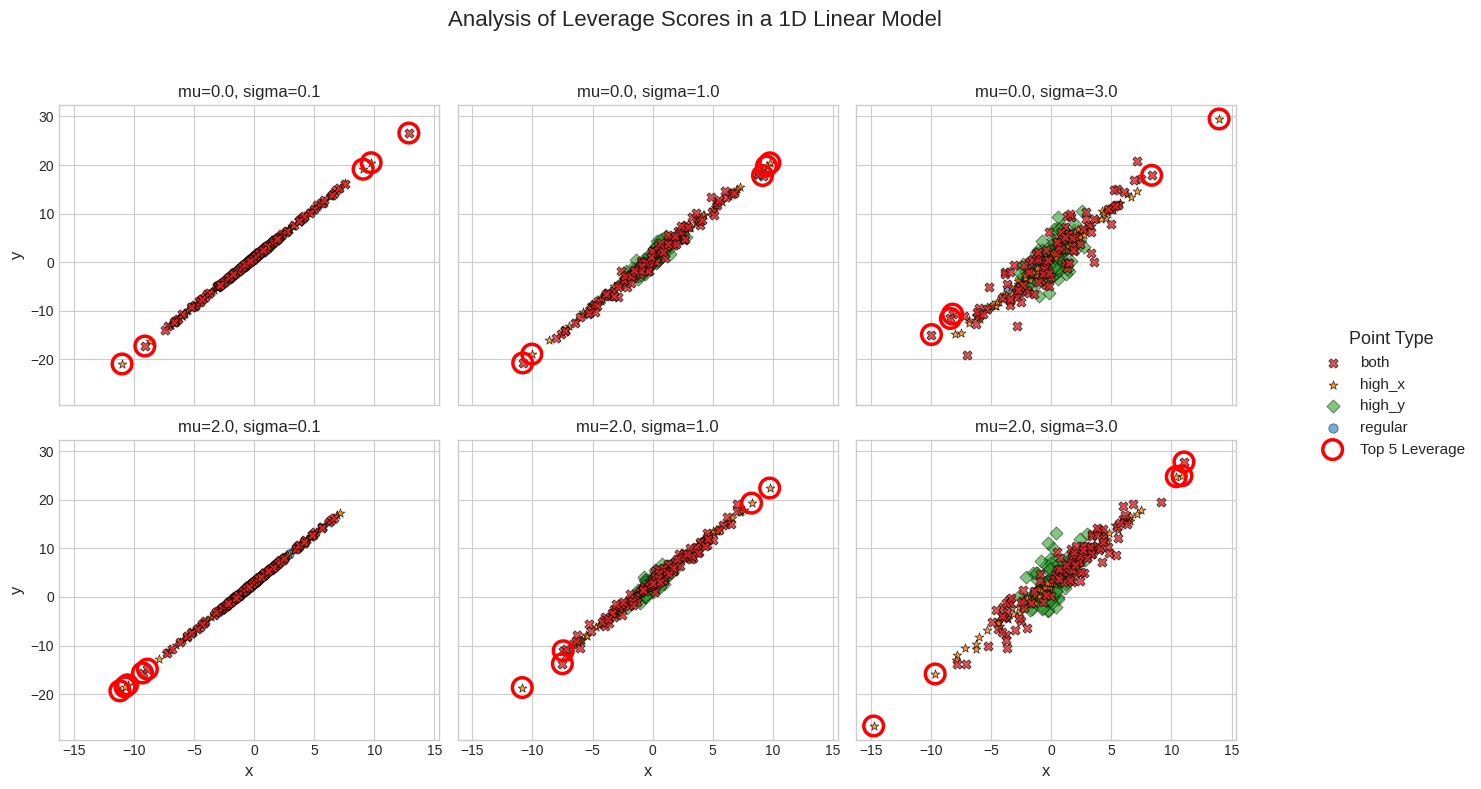

In [28]:
# --- 1D Experiment ---
fig1, axs1 = plt.subplots(len(mu_list), len(sigma_list), 
                        figsize=(14, 8),
                        sharex=True, sharey=True, squeeze=False)

print("Running 1D Experiment...")
for i, mu in enumerate(mu_list):
    for j, sigma in enumerate(sigma_list):
        ax = axs1[i, j]
        x, y, labels = generate_1d_data(rng, mu, sigma, n_per_type)
        X = np.column_stack([x, np.ones_like(x)])
        h = calculate_leverage_scores(X)
        plot_leverage_results(ax, (x, None, y), labels, h, top_k)
        ax.set_title(f"mu={mu}, sigma={sigma}", fontsize=12)

for ax in axs1[-1, :]:
    ax.set_xlabel("x", fontsize=12)
for ax in axs1[:, 0]:
    ax.set_ylabel("y", fontsize=12)

# Create a single, cleaner legend for the entire figure
handles, plot_labels = axs1[0,0].get_legend_handles_labels()
fig1.legend(handles, plot_labels,
            loc='center right',          # Position
            bbox_to_anchor=(1.06, 0.5),  # Fine-tune position
            fontsize=11,
            title='Point Type',          # Add a title to the legend
            title_fontsize=13,
            fancybox=True,
            shadow=True)

fig1.suptitle("Analysis of Leverage Scores in a 1D Linear Model", fontsize=16)
fig1.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

1. We consistently observe across all six plots that the points with the highest leverage scores are always from the `high_x` and `both` categories. These are the points that were generated with a large variance in their x-position, placing them far from the center of the data.

2. The `high_y` points, which are clear vertical outliers, never have high leverage. This demonstrates that leverage is a measure of a point's potential influence based solely on its extremity in the feature space, not its residual error. A point can be an outlier without being influential.

3. By varying the noise parameters $\sigma$ and $\mu$, we confirmed that this principle holds true. Increasing the vertical scatter ($\sigma$) or shifting the data vertically ($\mu$) had no effect on which points were identified as high-leverage.

The experiment clearly shows that leverage is a property of the predictors ($X$ matrix) alone. The points that have the most power to 'pull' on the regression line are those at the edges of the data, regardless of whether they actually fit the trend or not."

Running 2D Experiment...


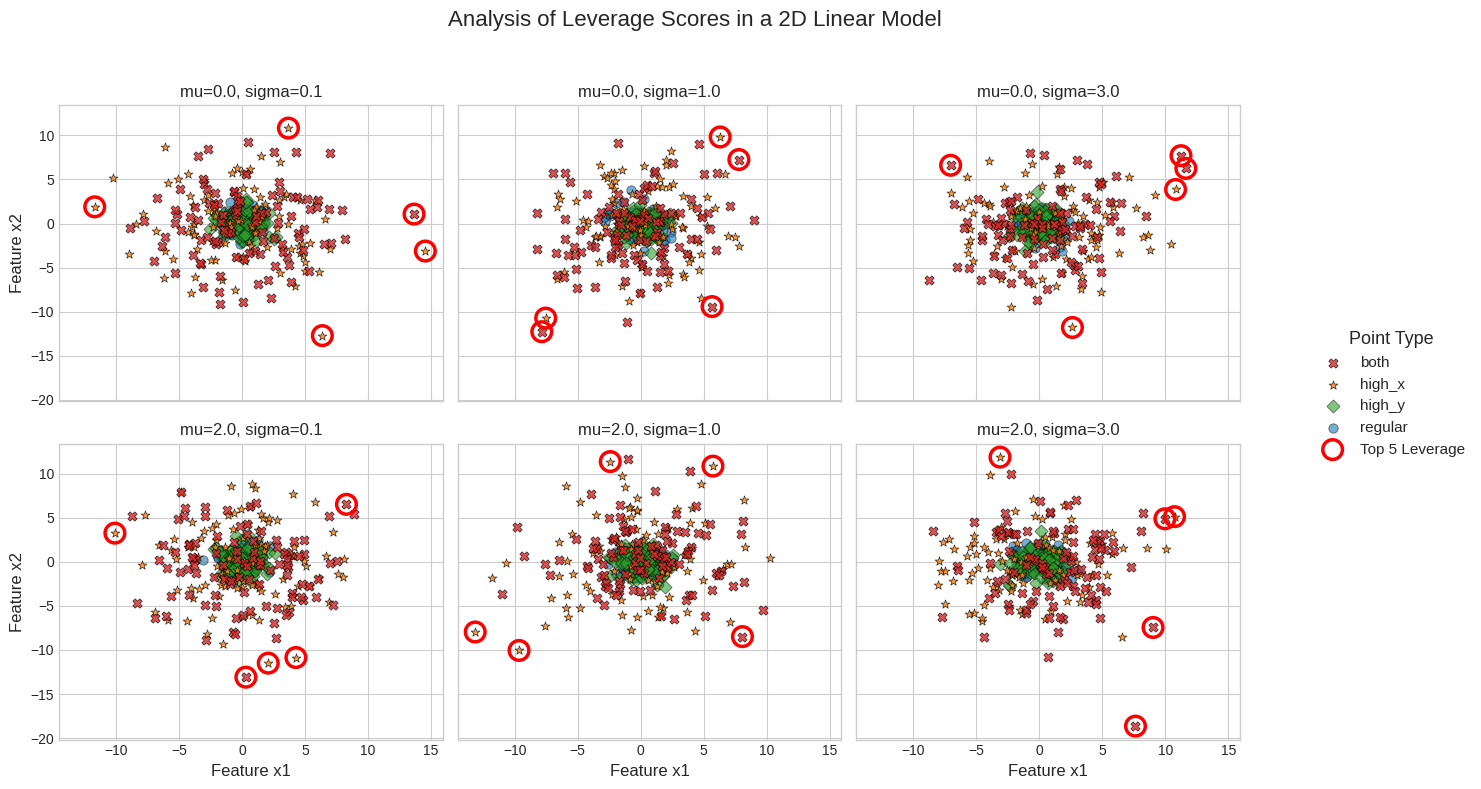

In [30]:
# ---` 2D Experiment ---
fig2, axs2 = plt.subplots(len(mu_list), len(sigma_list), 
                        figsize=(14, 8),
                        sharex=True, sharey=True, squeeze=False)

print("Running 2D Experiment...")
for i, mu in enumerate(mu_list):
    for j, sigma in enumerate(sigma_list):
        ax = axs2[i, j]
        x1, x2, y, labels = generate_2d_data(rng, mu, sigma, n_per_type)
        X = np.column_stack([x1, x2, np.ones_like(x1)])
        h = calculate_leverage_scores(X)
        plot_leverage_results(ax, (x1, x2, y), labels, h, top_k)
        ax.set_title(f"mu={mu}, sigma={sigma}", fontsize=12) # Simplified title

for ax in axs2[-1, :]:
    ax.set_xlabel("Feature x1", fontsize=12)
for ax in axs2[:, 0]:
    ax.set_ylabel("Feature x2", fontsize=12)
        
handles, plot_labels = axs2[0,0].get_legend_handles_labels()
fig2.legend(handles, plot_labels,
            loc='center right',          # Position
            bbox_to_anchor=(1.06, 0.5),  # Fine-tune position
            fontsize=11,
            title='Point Type',          # Add a title to the legend
            title_fontsize=13,
            fancybox=True,
            shadow=True)
fig2.suptitle("Analysis of Leverage Scores in a 2D Linear Model", fontsize=16)
fig2.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

1. The plots clearly show that high-leverage points are those that lie on the perimeter of the feature space. These are the points whose $(x_1, x_2)$ coordinates are farthest from the multivariate center, or 'center of gravity,' of the data.

2. This confirms that leverage isn't just about a single feature being extreme, but about the combination of features being unusual. The points circled in red are outliers in the 2D feature space itself.

3. Once again, the `high_y`  points, which are outliers in the $y$ dimension, exhibit low leverage because their feature coordinates are typical. This reinforces the critical distinction between a point's residual (its error) and its leverage (its potential to influence the model).

Both the $1D$ and $2D$ experiments lead to the same definitive conclusion:
Leverage is a property inherent to the features ($X$ matrix) and is independent of the outcome variable ($y$)."

#### Ex.2   

Using the function **generate_data_clusters** generate a $2$-dimentional dataset with $400$ train samples and $200$ test samples that are organized in $2$ clusters, with $0.1$ contamination. Train **KNN** from **pyod.models.knn**. Use $4$ subplots in order to display using different colors (for inliers and outliers):
- ground truth labels for training data
- predicted labels for training data
- ground truth labels for test data
- predicted labels for test data

Use different values for the **n_neighbours** parameter and observe how this affects the detection of small clusters of anomalies. Also compute the balanced accuracy for each parameter

In [37]:
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from sklearn.metrics import balanced_accuracy_score
from matplotlib.lines import Line2D

In [41]:
def plot_results(ax, X, y_true, y_pred, title_prefix, cmap):
    bacc = balanced_accuracy_score(y_true, y_pred)
    fp_mask = (y_pred == 1) & (y_true == 0)
    fn_mask = (y_pred == 0) & (y_true == 1)
    
    # Plot all points, colored by their PREDICTED label
    ax.scatter(X[:, 0], X[:, 1], c=[cmap[l] for l in y_pred], edgecolor='k', s=35, alpha=0.7)
    
    # Highlight False Positives with a hollow red circle
    ax.scatter(X[fp_mask, 0], X[fp_mask, 1], 
               facecolors='none', edgecolors='red', s=150, linewidths=2,
               label='False Positive')
    
    # Highlight False Negatives with a bold red 'X'
    ax.scatter(X[fn_mask, 0], X[fn_mask, 1], 
               marker='X', c='red', s=100,
               label='False Negative')
    
    fp_count = np.sum(fp_mask)
    fn_count = np.sum(fn_mask)
    title = (f"{title_prefix}\nBAcc = {bacc:.3f} "
             f"(FP: {fp_count}, FN: {fn_count})")
    ax.set_title(title, fontsize=12)

Processed k=1
Processed k=5
Processed k=10
Processed k=20


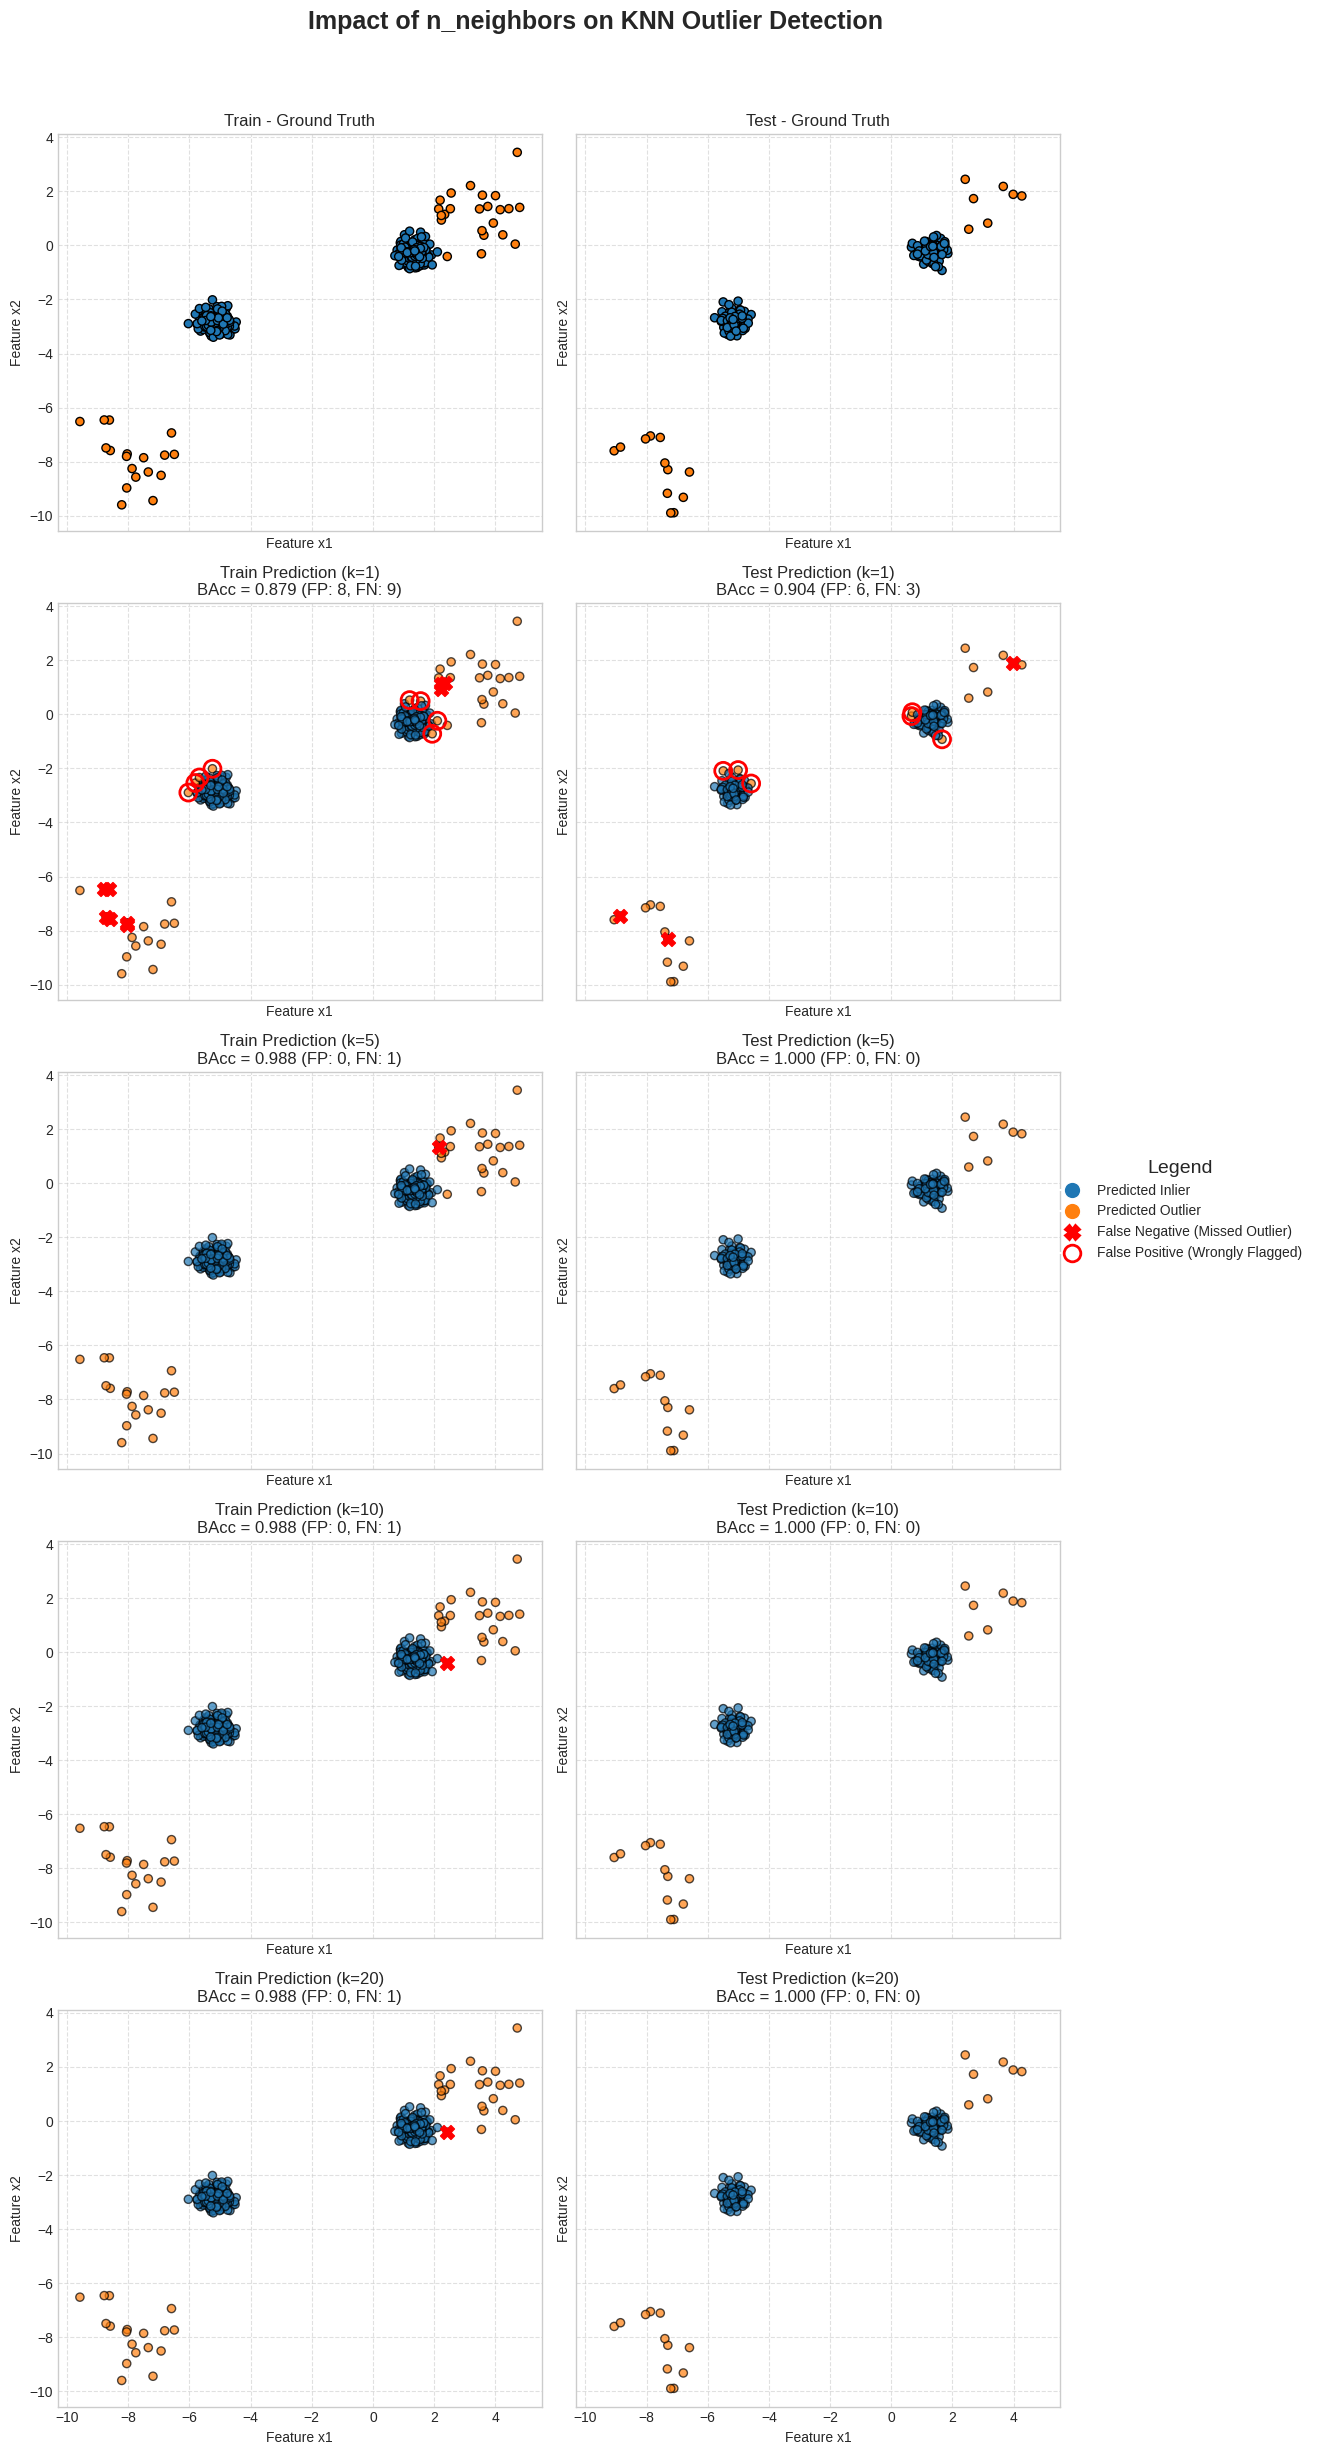

In [43]:
rng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = generate_data_clusters(
    n_train=400, n_test=200, n_clusters=2, n_features=2,
    contamination=0.1, size='same', density='same', dist=0.25,
    random_state=rng
)
n_neighbors_list = [1, 5, 10, 20]
cmap = {0: '#1f77b4', 1: '#ff7f0e'} # Blue for inliers, Orange for outliers

fig, axs = plt.subplots(len(n_neighbors_list) + 1, 2, 
                        figsize=(12, 5 * (len(n_neighbors_list) + 1)),
                        sharex=True, sharey=True)
fig.suptitle("Impact of n_neighbors on KNN Outlier Detection", fontsize=18, weight='bold')

axs[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=[cmap[l] for l in y_train], edgecolor='k', s=35)
axs[0, 0].set_title("Train - Ground Truth", fontsize=12)

axs[0, 1].scatter(X_test[:, 0], X_test[:, 1], c=[cmap[l] for l in y_test], edgecolor='k', s=35)
axs[0, 1].set_title("Test - Ground Truth", fontsize=12)

for i, n_neighbors in enumerate(n_neighbors_list):
    clf = KNN(n_neighbors=n_neighbors)
    clf.fit(X_train)

    y_train_pred = clf.labels_
    y_test_pred  = clf.predict(X_test)

    row_idx = i + 1
    plot_results(axs[row_idx, 0], X_train, y_train, y_train_pred, f"Train Prediction (k={n_neighbors})", cmap)
    plot_results(axs[row_idx, 1], X_test, y_test, y_test_pred, f"Test Prediction (k={n_neighbors})", cmap)
    
    print(f"Processed k={n_neighbors}")

for ax in axs.flat:
    ax.set_xlabel("Feature x1")
    ax.set_ylabel("Feature x2")
    ax.grid(True, linestyle='--', alpha=0.6)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Predicted Inlier', markerfacecolor=cmap[0], markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Predicted Outlier', markerfacecolor=cmap[1], markersize=12),
    Line2D([0], [0], marker='X', color='red', label='False Negative (Missed Outlier)', markersize=10, linestyle='None', markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', label='False Positive (Wrongly Flagged)', markeredgecolor='red', markersize=12, markeredgewidth=2, markerfacecolor='none')
]

fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5), fontsize=10, title='Legend', title_fontsize=14)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()

1. Low $k$ has **high sensitivity, high false postiives** ($k = 1$)
- has the lowest Balanced Accuracy.
- a very high number of False Positives.
- since the model's decision is based only on the single nearest neighbor. This makes it extremely sensitive to local variations in density. Any inlier that happens to be slightly isolated from the core of its cluster is immediately flagged as an outlier.
- we can conclude that a very small $k$ makes the model too aggressive and noisy.

2. Optimal $k$ has **the best balance** ($k = 5$)
- performance improves dramatically.
- the model achieves a perfect score on the test set and only misses one outlier in the training set 
- by considering a small neighborhood of 5 points, the model smooths out its decision boundary. A point on the edge of a cluster is no longer considered an outlier because its 5 nearest neighbors are still other inliers. This makes the model more robust.
- we can conclude that for this specific dataset, $ k = 5$ provides the best balance between being sensitive enough to catch outliers and robust enough to not overreact to the natural structure of the inlier clusters.

3. High $k$ has **increased robustness, but we have the risk of missing outliers** ($k = 10, k = 20$)
- with $k=10$ and $k=20$ we also perform very well, maintaining a perfect score on the test data. 
- they continue to have one False Negative in the training data.
- the single missed outlier (the red 'X') is a point that is relatively close to the main cluster. 
- with a large enough k, its neighborhood includes enough inliers from the main cluster that the model is "fooled" into thinking it's also an inlier. 


Too Low $k$ leads to a high-variance model that is overly sensitive to local noise, resulting in many False Positives.

Too High $k$ Leads to a high-bias model that may over-smooth the decision boundary, potentially missing outliers that are close to normal clusters and causing False Negatives.

#### Ex. 3

In this exercise we will see the limitations of distance based algorithms like **KNN**. Specifically, we will observe how **KNN** behaves when our data clusters have different densities and how **pyod.models.lof.LOF** solves the problem by
considering the variations of the local densities of the datapoints. First, generate $2$ clusters ($200$ and $100$ samples respectively) with $2$-dimensional samples using $(-10, -10)$ and $(10, 10)$ as centers, $2$ and $6$ as standard deviations using **sklearn.datasets.make_blobs()** function. Then, fit **KNN** and **LOF** with the generated data using a small contamination rate ($0.07$) and find the predicted labels. Use $2$ subplots (using different colors inliers and outliers) the $2$ clusters and observe the $2$ models behave for different **n_neighbors**.

![example](./imgs/Lab2.png)

In [71]:
from sklearn.datasets import make_blobs
from pyod.models.lof import LOF

In [72]:
def plot_results(ax, X, y_true, y_pred, title_prefix, cmap):
    bacc = balanced_accuracy_score(y_true, y_pred)
    fp_mask = (y_pred == 1) & (y_true == 0)
    fn_mask = (y_pred == 0) & (y_true == 1)
    
    ax.scatter(X[:, 0], X[:, 1], c=[cmap[l] for l in y_pred], edgecolor='k', s=35, alpha=0.7)
    ax.scatter(X[fp_mask, 0], X[fp_mask, 1], facecolors='none', edgecolors='red', s=150, linewidths=2)
    ax.scatter(X[fn_mask, 0], X[fn_mask, 1], marker='X', c='red', s=100)

    fp_count = np.sum(fp_mask)
    fn_count = np.sum(fn_mask)
    title = (f"{title_prefix}\nBAcc = {bacc:.3f} (FP: {fp_count}, FN: {fn_count})")
    ax.set_title(title, fontsize=12) 

contamination set to 0.0683, n_total=322


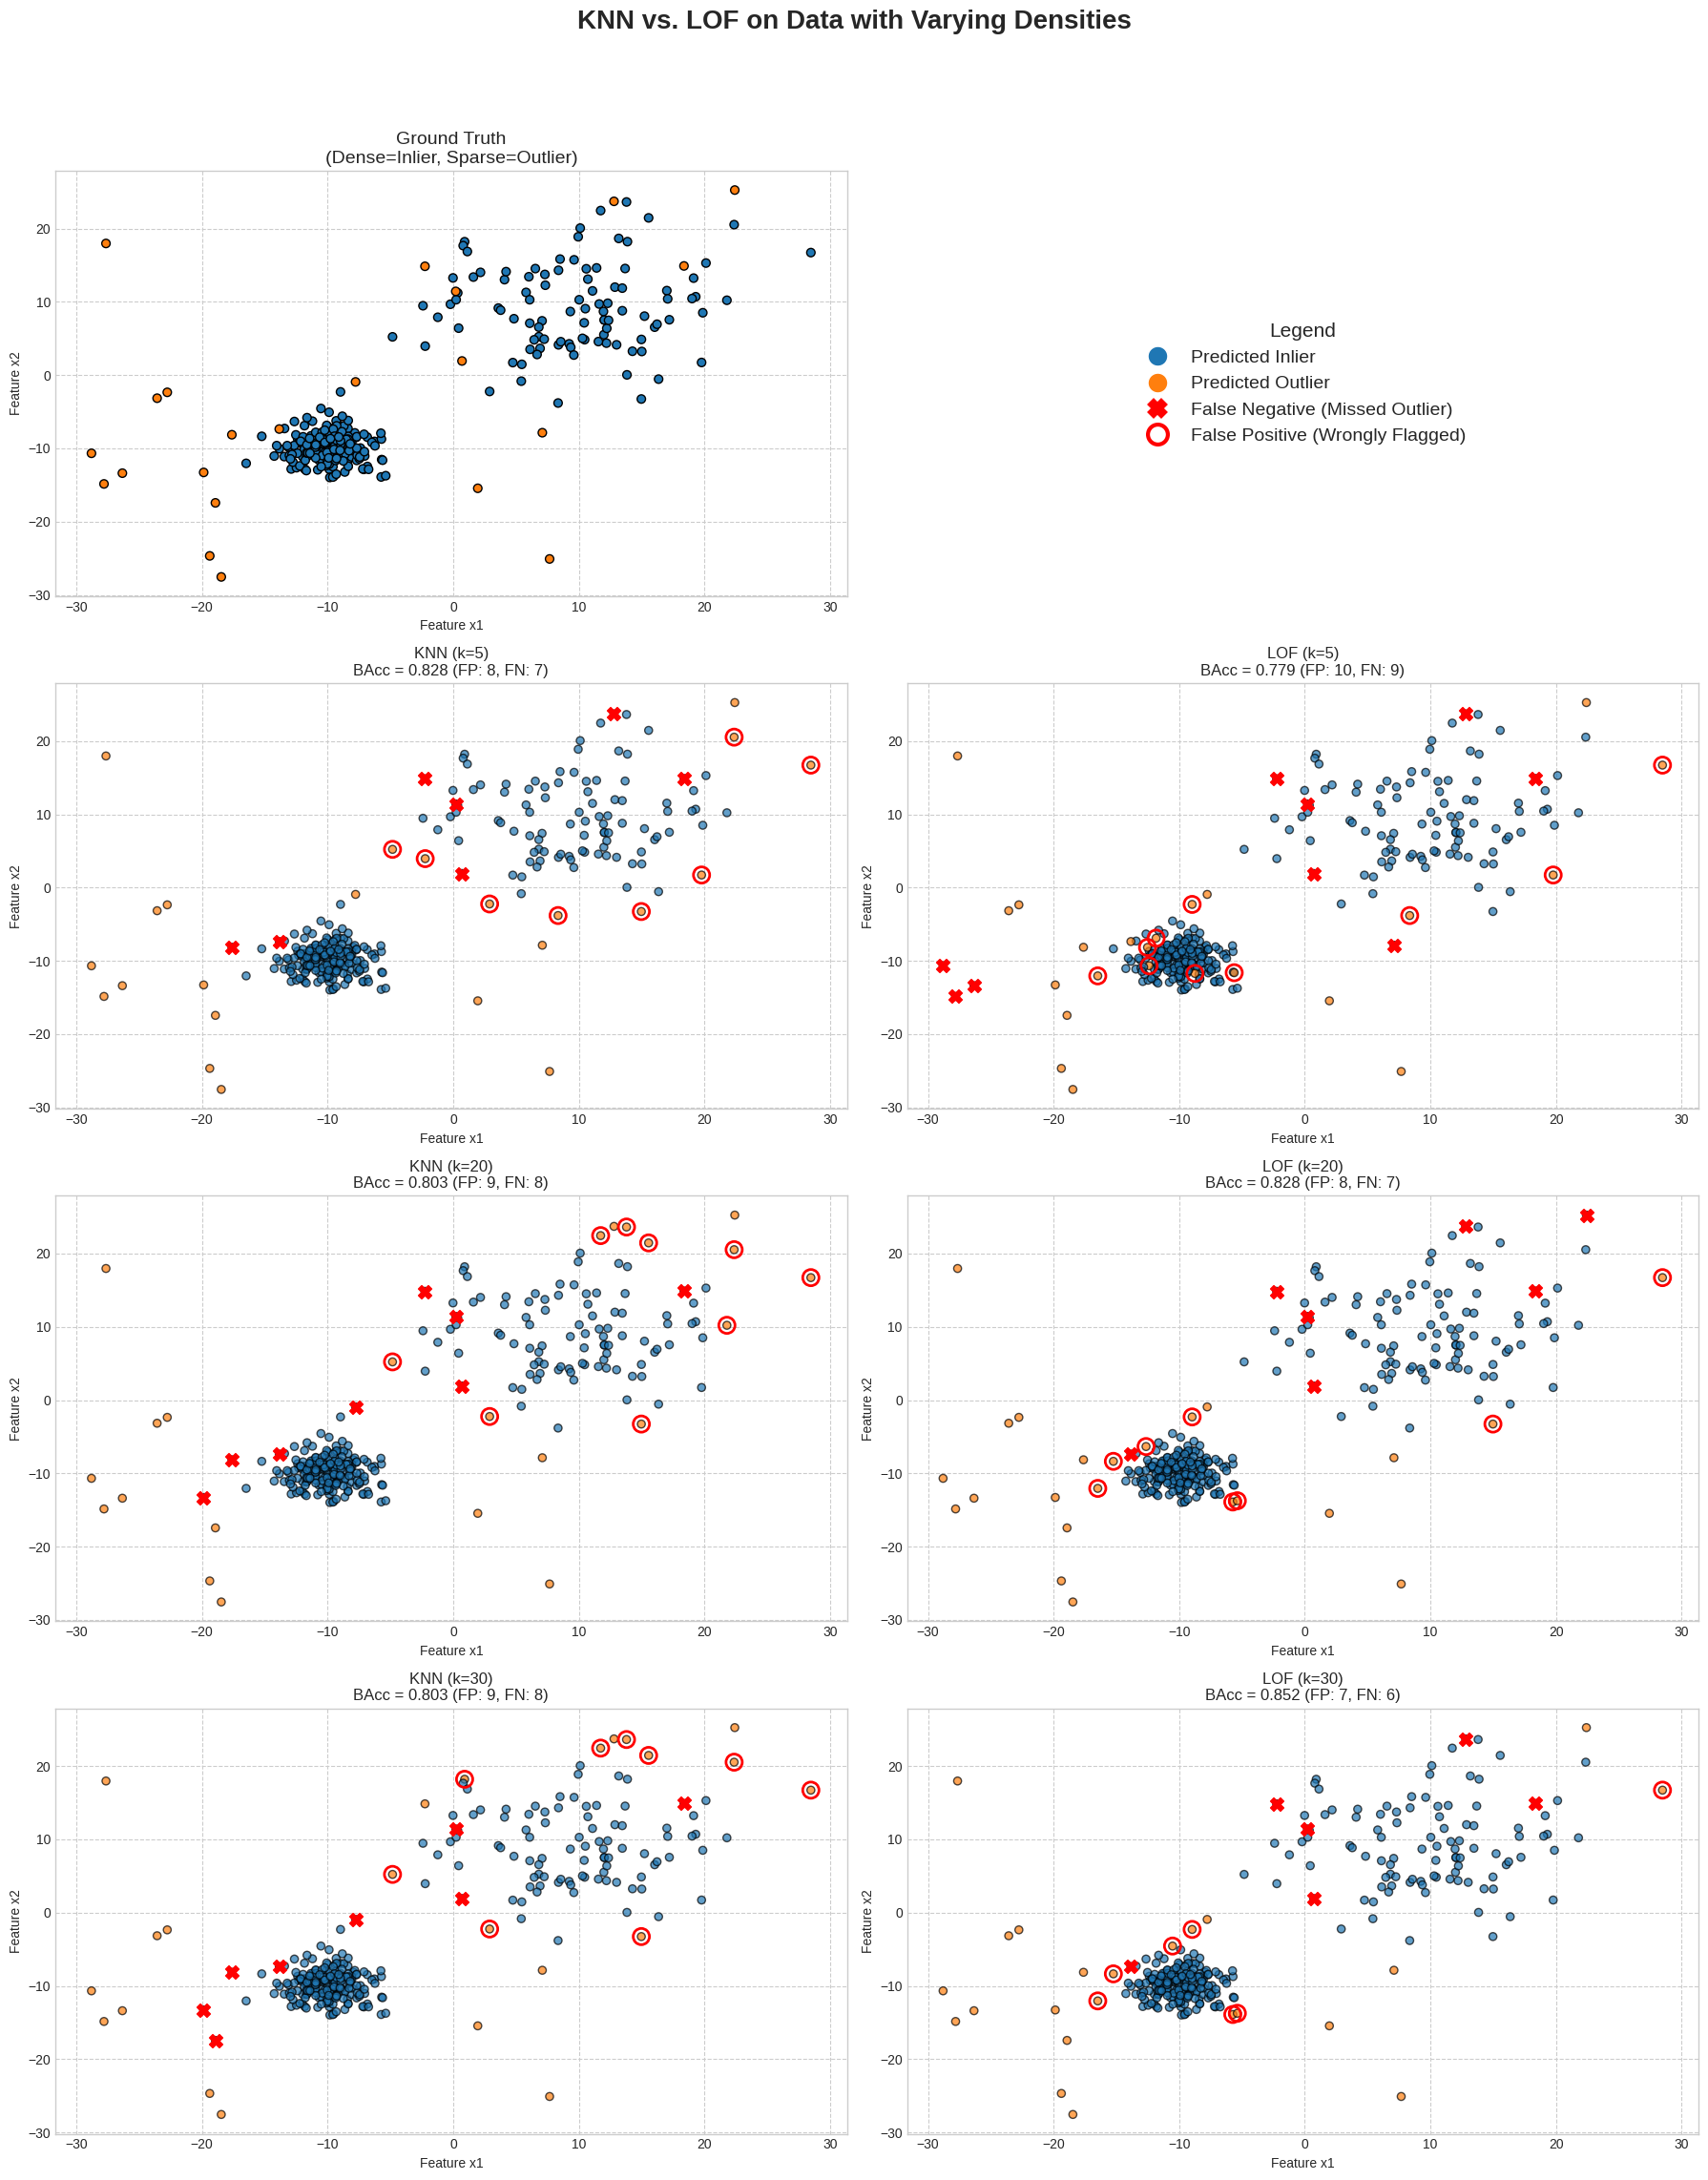

In [81]:
n_samples = [200, 100]
X, cluster_labels = make_blobs(n_samples=n_samples,
                               centers=[[-10, -10], [10, 10]],
                               cluster_std=[2, 6],
                               random_state=42)

base_n = X.shape[0]
contamination = 0.07
n_out = int(np.ceil(contamination * base_n))
outliers = rng.uniform(low=-30, high=30, size=(n_out, 2))
X = np.vstack([X, outliers])
y_true = np.hstack([np.zeros(base_n, dtype=int), np.ones(n_out, dtype=int)])
contamination = float(y_true.sum()) / y_true.size

print(f"contamination set to {contamination:.4f}, n_total={X.shape[0]}")

n_neighbors_list = [5, 20, 30]
cmap = {0: '#1f77b4', 1: '#ff7f0e'} 

true_contamination = 0.07
fig, axs = plt.subplots(len(n_neighbors_list) + 1, 2,
                        figsize=(18, 6 * (len(n_neighbors_list) + 1)))
fig.suptitle("KNN vs. LOF on Data with Varying Densities", fontsize=20, weight='bold')

ax_gt = axs[0, 0]
ax_gt.scatter(X[:, 0], X[:, 1], c=[cmap[l] for l in y_true], edgecolor='k', s=40)
ax_gt.set_title("Ground Truth\n(Dense=Inlier, Sparse=Outlier)", fontsize=14)

for i, k in enumerate(n_neighbors_list):
    row_idx = i + 1
    
    # KNN Model
    clf_knn = KNN(n_neighbors=k, contamination=true_contamination)
    clf_knn.fit(X)
    y_knn = clf_knn.labels_
    
    # LOF Model
    clf_lof = LOF(n_neighbors=k, contamination=true_contamination)
    clf_lof.fit(X)
    y_lof = clf_lof.labels_

    plot_results(axs[row_idx, 0], X, y_true, y_knn, f"KNN (k={k})", cmap)
    plot_results(axs[row_idx, 1], X, y_true, y_lof, f"LOF (k={k})", cmap)
    
for ax in axs.flat:
    ax.set_xlabel("Feature x1")
    ax.set_ylabel("Feature x2")
    ax.grid(True, linestyle='--')

legend_ax = axs[0, 1]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Predicted Inlier', markerfacecolor=cmap[0], markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Predicted Outlier', markerfacecolor=cmap[1], markersize=15),
    Line2D([0], [0], marker='X', color='red', label='False Negative (Missed Outlier)', markersize=12, linestyle='None', markeredgewidth=3),
    Line2D([0], [0], marker='o', color='w', label='False Positive (Wrongly Flagged)', markeredgecolor='red', markersize=15, markeredgewidth=3, markerfacecolor='none')
]
# Turn off the axis frame and ticks for the legend subplot
legend_ax.axis('off') 
legend_ax.legend(handles=legend_elements, loc='center', fontsize=14, title='Legend', title_fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- KNN's performance is almost static across all values of k (from $5$ to $50$), with a Balanced Accuracy Score (BAcc) stuck around $0.803$ - $0.828$.
- KNN consistently and incorrectly flags points on the outer edges of the dense cluster as outliers.
- KNN doesn't understand the concept of a cluster boundary. Because the sparse cluster exists, the global distance scale is warped, and these edge points get high outlier scores. 

- LOF compares the local density of a point to the local densities of its neighbors. An outlier is a point that is in a region of significantly lower density than its neighbors.
- LOF shows a clear trend of improvement as k increases. The BAcc score rises steadily from a poor $0.779$ ($k=5$) to a good $A0.828$ ($k=20$) and finally to the best score of $0.852$ ($k=50$).
- as `k` grows, LOF gets a better understanding of what the "local neighborhood" density should be.

- KNN cannot improve because its underlying logic is too simple for this problem. It will always be confused by the dense cluster's edges.
- LOF shows that its more complex, density-based logic is a better context to correctly distinguish between a point on the edge of a cluster and a true, isolated outlier.

#### Ex.4 

For this exercise we will need the cardio dataset from (https://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/). Load the data using **scipy.io.loadmat()** and use **train_test_split()** to split it into train and test subsets. Normalize your data accordingly. You will use an ensemble of classifiers of the same
type (**KNN** and **LOF**) in order to create an average/maximization strategy (average/maximum score will be returned). Create $10$ KNN/LOF models for which you vary parameter `n_neighbors` from $30$ to $120$ (here you can use other intervals/steps if you observe that they produce better results). Fit each model, print the balanced accuracy (BA) for train/test data and store both the train and test scores in order to use them later. Normalize both scores using **pyod.utils.utility.standardizer()** and use **pyod.models.combination.average()** and **pyod.models.combination.average()** to find the final scores for
the 2 strategies. For each of them find the threshold used for classification (using **numpy.quantile()** with the known contamination rate of the dataset), compute the predictions and print the balanced accuracy (BA). 

In [97]:
import os
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyod.utils.utility import standardizer
from pyod.models.combination import average, maximization

In [98]:
# --- Load dataset ---
mat_path = "data/cardio.mat"
if not os.path.exists(mat_path):
    raise FileNotFoundError(f"File not found: {mat_path}. Set mat_path to the cardio .mat file.") 
md = loadmat(mat_path)

In [99]:
def find_data_from_keys(data_dict, possible_keys):
    for key in possible_keys:
        if key in data_dict:
            return data_dict[key]
    return None # Return None if no key was found

possible_X_keys = ['X', 'data', 'features', 'X_all', 'A']
possible_y_keys = ['y', 'labels', 'Y', 'target']

X_all = find_data_from_keys(md, possible_X_keys)
y_all = find_data_from_keys(md, possible_y_keys)

if X_all is None or y_all is None:
    raise RuntimeError("Could not identify X and y in the .mat file using standard names.")

# Ensure labels are 0/1 integer
y_all = np.asarray(y_all).astype(int).ravel()

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.33, random_state=42, stratify=y_all if len(np.unique(y_all))>1 else None
)

# standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# infer contamination from labels if available, otherwise set manually
contamination = float(y_train.sum()) / y_train.size if y_train.sum() > 0 else 0.1
print(f"Inferred contamination = {contamination:.4f}")

Inferred contamination = 0.0962


In [101]:
n_models = 10
n_neighbors_list = np.linspace(30, 120, n_models, dtype=int)  # 10 values from 30 to 120

def run_ensemble(ModelClass, model_name):
    print(f"\nRunning ensemble for {model_name} (n_models={n_models})")
    train_scores = np.zeros((X_train.shape[0], n_models))
    test_scores  = np.zeros((X_test.shape[0], n_models))

    for i, k in enumerate(n_neighbors_list):
        clf = ModelClass(n_neighbors=int(k), contamination=contamination)
        clf.fit(X_train)

        # pyod provides decision_scores_ for train; use decision_function for test if available
        train_scores[:, i] = clf.decision_scores_ if hasattr(clf, 'decision_scores_') else clf.decision_function(X_train)

        # for test, prefer decision_function; fall back to raw score method if necessary
        if hasattr(clf, 'decision_function'):
            test_scores[:, i] = clf.decision_function(X_test)
        else:
            test_scores[:, i] = clf.predict_proba(X_test)[:, 1]  # unlikely branch

        # compute and print balanced accuracy for this single model (using threshold from train)
        thr = np.quantile(train_scores[:, i], 1.0 - contamination)  # higher score -> more anomalous

        y_train_pred = (train_scores[:, i] > thr).astype(int)
        y_test_pred  = (test_scores[:, i]  > thr).astype(int)
        
        bacc_train = balanced_accuracy_score(y_train, y_train_pred)
        bacc_test  = balanced_accuracy_score(y_test,  y_test_pred)

        print(f"k={k:3d}  | Train BAcc={bacc_train:.3f}  Test BAcc={bacc_test:.3f}")

    # standardize scores (zero-mean unit-variance) across models per-sample axis
    s_train, s_test = standardizer(train_scores, test_scores)

    # combination strategies
    for comb_fn, comb_name in [(average, "Average"), (maximization, "Maximization")]:
        comb_train_scores = comb_fn(s_train) 
        comb_test_scores  = comb_fn(s_test) 

        thr_comb = np.quantile(comb_train_scores, 1.0 - contamination)
        y_train_comb = (comb_train_scores > thr_comb).astype(int)
        y_test_comb  = (comb_test_scores  > thr_comb).astype(int)

        bacc_train = balanced_accuracy_score(y_train, y_train_comb)
        bacc_test  = balanced_accuracy_score(y_test,  y_test_comb)
        print(f"--> {comb_name} comb. | Train BAcc={bacc_train:.3f}  Test BAcc={bacc_test:.3f} | threshold={thr_comb:.4f}")

    return {
        "train_scores": train_scores,
        "test_scores": test_scores,
        "std_train": s_train,
        "std_test": s_test
    }

knn_results = run_ensemble(KNN, "KNN")
lof_results = run_ensemble(LOF, "LOF")


Running ensemble for KNN (n_models=10)
k= 30  | Train BAcc=0.709  Test BAcc=0.666
k= 40  | Train BAcc=0.719  Test BAcc=0.676
k= 50  | Train BAcc=0.728  Test BAcc=0.685
k= 60  | Train BAcc=0.728  Test BAcc=0.711
k= 70  | Train BAcc=0.742  Test BAcc=0.719
k= 80  | Train BAcc=0.752  Test BAcc=0.729
k= 90  | Train BAcc=0.752  Test BAcc=0.738
k=100  | Train BAcc=0.756  Test BAcc=0.738
k=110  | Train BAcc=0.756  Test BAcc=0.738
k=120  | Train BAcc=0.761  Test BAcc=0.747
--> Average comb. | Train BAcc=0.733  Test BAcc=0.719 | threshold=0.9774
--> Maximization comb. | Train BAcc=0.756  Test BAcc=0.728 | threshold=1.0542

Running ensemble for LOF (n_models=10)
k= 30  | Train BAcc=0.545  Test BAcc=0.561
k= 40  | Train BAcc=0.545  Test BAcc=0.543
k= 50  | Train BAcc=0.550  Test BAcc=0.546
k= 60  | Train BAcc=0.573  Test BAcc=0.569
k= 70  | Train BAcc=0.601  Test BAcc=0.574
k= 80  | Train BAcc=0.630  Test BAcc=0.601
k= 90  | Train BAcc=0.648  Test BAcc=0.620
k=100  | Train BAcc=0.662  Test BAcc=0

`KNN`:
- test accuracy for individual KNN models steadily increases from $0.666$ at $k=30$ to $0.747$ at $k=120$. 
- this is a strong indicator that for this specific dataset, a larger neighborhood size is better for identifying anomalies. 
- this might mean the normal data points form large, dense clusters, and outliers are truly far from these clusters (global outliers).

`LOF`:
- performance is much weaker than `KNN` (slightly better than random guessing).
- the underlying assumption of `LOF` (outliers are in areas of significantly lower local density) may not hold true for this dataset.
- performance improves as $k$ increases, going from a test accuracy of $0.561$ at $k=30$ to $0.661$ at $k=120$


- `KNN`: Maximization ($0.728$) > Average ($0.719$)
- `LOF`: Maximization ($0.622$) > Average ($0.580$)

Maximization works better. 
This implies that if even one of the models is very confident that a point is an outlier, that is a more reliable signal than the "average opinion" of all models.

